<a href="https://colab.research.google.com/github/ariabishma/JIPITI/blob/main/Puisi_Generator_Jipiti_Melow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import tensorflow as tf
import numpy as np 
from tensorflow.keras.layers import TextVectorization, Dense, Input, Embedding, Layer, Dropout
import matplotlib.pyplot as plt

In [4]:
with open('./puisimini.txt', 'r', encoding='utf-8') as f:
    text = f.readlines()

In [5]:
context_size = 8
n_embd = 64
n_dropout = .2

In [6]:
vectorizer = TextVectorization(max_tokens=1000,ragged=True)
# vectorizer = TextVectorization(split="character",ragged=True)
vectorizer.adapt(text)

vocabs = vectorizer.get_vocabulary()

decode = lambda encoded : ' '.join([vocabs[i] for i in encoded])

vocab_size = vectorizer.vocabulary_size()
data = vectorizer(text).flat_values
data_size = data.shape[0]

In [7]:
vocab_size

169

In [8]:
xb = np.array([data[d:d+context_size] for d in range(data_size-context_size-1)])
yb = np.array([data[d+1:d+1+context_size] for d in range(data_size-context_size-1)])

In [9]:
class Block(tf.keras.layers.Layer):
  def __init__(self):
    super(Block, self).__init__()
    # Attention head
    self.query = Dense(n_embd, use_bias=False, name="attention_query")
    self.key = Dense(n_embd, use_bias=False, name="attention_key")
    self.value = Dense(n_embd, use_bias=False, name="attention_value")

  def call(self, x):
    query = self.query(x)
    key = self.key(x)
    value = self.value(x)

    logits = query @ tf.transpose(key,perm=[0,2,1])
    mask = tf.linalg.band_part(tf.ones_like(logits ,dtype='bool'), -1, 0)
    
    logits = tf.where(mask, logits, float('-inf'))

    logits = tf.nn.softmax(logits / np.sqrt(n_embd))
    logits = logits @ value 

    return logits

In [10]:
class PuisiGenerator(tf.keras.Model):
  def __init__(self):
    super(PuisiGenerator,self).__init__()
    self.embedding = tf.keras.layers.Embedding(vocab_size,n_embd)
    self.positional_embedding_table = Embedding(context_size, n_embd)
    
    # decoder block
    self.block = Block()

    self.ffn1 = tf.keras.layers.Dense(n_embd * 4, activation='relu')
    self.dropout = tf.keras.layers.Dropout(n_dropout)
    self.head = tf.keras.layers.Dense(vocab_size)
  
  def call(self, x):
    logits = self.embedding(x)
    pos_embd = self.positional_embedding_table(tf.range(context_size))
    logits = logits + pos_embd 

    logits = self.block(logits)

    logits = self.ffn1(logits)
    logits = self.dropout(logits)
    softmax = self.head(logits)

    return softmax

In [11]:
mini_batch = xb[:10]

In [12]:
model = PuisiGenerator()
softmax = model(mini_batch)

In [13]:
model.compile(optimizer='adam',loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True))

In [14]:
history = model.fit(xb,yb, validation_split=.3, epochs=100, shuffle=True)

Epoch 1/100
11/11 [==============================] - 3s 73ms/step - loss: 5.1157 - val_loss: 5.0940
Epoch 2/100
11/11 [==============================] - 0s 24ms/step - loss: 5.0461 - val_loss: 4.9890
Epoch 3/100
11/11 [==============================] - 0s 27ms/step - loss: 4.8466 - val_loss: 4.8064
Epoch 4/100
11/11 [==============================] - 0s 26ms/step - loss: 4.6974 - val_loss: 4.7601
Epoch 5/100
11/11 [==============================] - 0s 22ms/step - loss: 4.6154 - val_loss: 4.6918
Epoch 6/100
11/11 [==============================] - 0s 24ms/step - loss: 4.5280 - val_loss: 4.6145
Epoch 7/100
11/11 [==============================] - 0s 13ms/step - loss: 4.4032 - val_loss: 4.5012
Epoch 8/100
11/11 [==============================] - 0s 13ms/step - loss: 4.2178 - val_loss: 4.3555
Epoch 9/100
11/11 [==============================] - 0s 18ms/step - loss: 3.9736 - val_loss: 4.1765
Epoch 10/100
11/11 [==============================] - 0s 14ms/step - loss: 3.6624 - val_loss: 3.9440

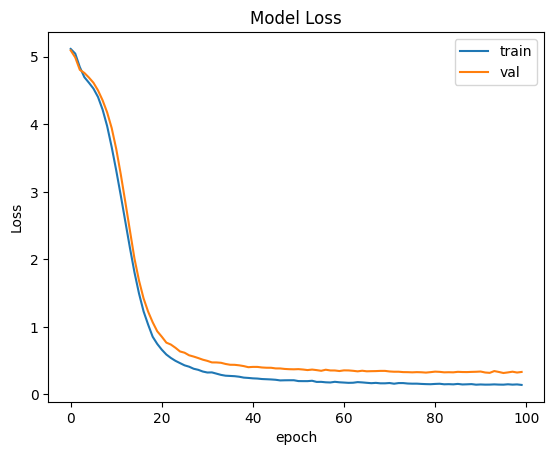

In [15]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'])
plt.show()

In [16]:
# context = vectorizer('Kau genggam kedua tanganku saat aku merasa takut Kaulah yang')
context = data[:context_size]
decode(context)

'kau adalah separuh hidup ku hanya kepadamu aku'

In [17]:
softmax = model(np.array([context]))

In [18]:
tf.math.log([[0.5, 0.8,0.3,.2,.2,.2,.2,.2,.2,.2]])

<tf.Tensor: shape=(1, 10), dtype=float32, numpy=
array([[-0.6931472 , -0.22314355, -1.2039728 , -1.609438  , -1.609438  ,
        -1.609438  , -1.609438  , -1.609438  , -1.609438  , -1.609438  ]],
      dtype=float32)>

In [19]:
p = tf.random.categorical(softmax[-1,-1:],100)
decode(p[0])

'berbagi berbagi berbagi berbagi berbagi berbagi berbagi berbagi berbagi berbagi berbagi berbagi berbagi berbagi berbagi berbagi berbagi berbagi berbagi berbagi berbagi berbagi berbagi berbagi berbagi berbagi berbagi berbagi berbagi berbagi berbagi berbagi berbagi berbagi berbagi berbagi berbagi berbagi berbagi berbagi berbagi berbagi berbagi berbagi berbagi berbagi berbagi berbagi berbagi berbagi berbagi berbagi berbagi berbagi berbagi berbagi berbagi berbagi berbagi berbagi berbagi berbagi berbagi berbagi berbagi berbagi berbagi berbagi berbagi berbagi berbagi berbagi berbagi berbagi berbagi berbagi berbagi berbagi berbagi berbagi berbagi berbagi berbagi berbagi berbagi berbagi berbagi berbagi berbagi berbagi berbagi berbagi berbagi berbagi berbagi berbagi berbagi berbagi berbagi berbagi'

In [20]:
decode(mini_batch[:1][0])

'kau adalah separuh hidup ku hanya kepadamu aku'

In [21]:
decode([tf.argmax(softmax[0,-1,:])])

'berbagi'

In [22]:
context = vectorizer('Aku menyayangimu Hingga tutup usiaku Bahkan hingga aku')
decoded = decode(context)
print(decoded)

full_text = ''
for i in range(100):
  context_new = context[-context_size:]
  softmax = model(np.array([context_new]))
  prediction = tf.random.categorical(softmax[-1,-1:],1)
  full_text += decode(prediction[0])+' '
  context = tf.concat([context,prediction[0]],axis=0)

aku [UNK] hingga tutup usiaku bahkan hingga aku


In [23]:
decoded+' '+full_text

'aku [UNK] hingga tutup usiaku bahkan hingga aku hidup lagi sangat sayang padamu sayang lahir dan batinku hingga akhir waktuku ibu jika di perkenankan aku ingin membalas itu segala yang kau berikan kau berikan padaku selama ini sungguh ibu aku ingin selalu bersamamu disisa usiaku ingin tetap bersamamuibukasihmu tak akan ada yang bisa menggantikannyaibu doa terakhirkuya tuhanlindungilah lindungilah di setiap langkah ibu ibu yang ku sayang ibu yang tak tergantikan ibu yang tak terduakan terimakasih ibu aku menyayangmu hingga tutup usiaku bahkan hingga aku hidup lagi perisai yang kau banggakan takkan jadi tameng bagimu aku mengerti betapa hebatnya perangkap mu hei sang dewi ku akan terus merasa terbiasa '